# Anomaly detection using LSTM

This notebook is an example for how to use Long-Short Term Memory neural networks for anomaly detection.

Data used in this example is taken from hardware sensors attached to a robot arm performing simple tasks. We will be using 3 values - linear acceleration X/Y/Z. The goal is to predict robot malfunction before it crashes (and before a person is able to notice it).

Network graph will be prepared using Keras/Tensorflow and the training itself will be performed using DeepWater.

## Setup

Import required modules (h2o for deepwater and pandas for initial data munging).

Bootstrap a single node H2O instance.

In [1]:
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator

h2o.init(port=54321, nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,15 hours 58 mins
H2O cluster version:,3.13.0.369
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_mateusz_6d08xa
H2O cluster total nodes:,1
H2O cluster free memory:,3.142 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Load and prepare data

In [2]:
import pandas as pd
import numpy as np
import random
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX = []
    for i in range(len(dataset)-look_back-1):
        a = np.append(dataset[i:(i+look_back),], [random.randint(0, 1000)/1e+20])
        dataX.append(a)
    return np.array(dataX)

# Read training data into memory
iot_raw = pd.read_csv('../model-builder/resources/normal_20170202_2229.csv')

# Select training columns
iot_train = iot_raw[[" LinAccX (g)"," LinAccY (g)"," LinAccZ (g)"]].as_matrix()

features = 3
look_back = 20

iot_train = create_dataset(iot_train, look_back)

# Send the data to H2O
iot_train_frame  = h2o.H2OFrame(iot_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Custom TF LSTM model

Build a custom LSTM network graph using Keras and save it for later use.

In [3]:
import tensorflow as tf
import json
from keras.layers.core import Reshape
from keras.layers import LSTM, RepeatVector
from keras import backend as K
from keras.objectives import categorical_crossentropy
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.training.rmsprop import RMSPropOptimizer

def keras_model(look_back, features, batch_size=1):
    input_dim = look_back * features
    latent_dim = 2

    classes = 1
    # always create a new graph inside ipython or
    # the default one will be used and can lead to
    # unexpected behavior
    graph = tf.Graph() 
    with graph.as_default():
        # Input images fed via H2O
        inp = tf.placeholder(tf.float32, [None, input_dim])
        # Actual labels used for training fed via H2O
        labels = tf.placeholder(tf.float32, [None, classes])
        
        # Keras network
        inputs = Reshape((look_back, features))(inp)

        encoded = LSTM(latent_dim, input_shape=(look_back, input_dim))(inputs)
        
        decoded = RepeatVector(look_back)(encoded)
        decoded = LSTM(features, return_sequences=True)(decoded)
        
        softmax = tf.nn.softmax_cross_entropy_with_logits(labels=inputs,logits=decoded)
        softmax = tf.reshape(softmax, [-1, batch_size, look_back])
        
        predictions = tf.reshape(tf.reduce_mean(softmax, axis=2), [batch_size, classes])
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=inputs,logits=decoded))
        
        train_step = RMSPropOptimizer(1.0).minimize(loss)

        init_op = tf.global_variables_initializer()

        # Metadata required by H2O
        tf.add_to_collection(ops.GraphKeys.INIT_OP, init_op.name)
        tf.add_to_collection(ops.GraphKeys.TRAIN_OP, train_step)
        tf.add_to_collection("logits", decoded)
        tf.add_to_collection("predictions", predictions)

        meta = json.dumps({
                "inputs": {"batch_image_input": inp.name,
                           "categorical_labels": labels.name},
                "outputs": {"categorical_logits": decoded.name,
                            "layers": ','.join([m.name for m in tf.get_default_graph().get_operations()])},
                "parameters": {}
            })
        tf.add_to_collection("meta", meta)

        # Save the meta file with the graph
        saver = tf.train.Saver()
        filename = "/tmp/keras_tf_lstm.meta"
        tf.train.export_meta_graph(filename, saver_def=saver.as_saver_def())

        return filename

Using TensorFlow backend.


## Train the model

In [4]:
batch_size = 64
model_filename = keras_model(look_back, features, batch_size)
model = H2ODeepWaterEstimator(epochs=100, 
                              network_definition_file=model_filename,
                              backend="tensorflow",
                              mini_batch_size = batch_size,
                              standardize=False
                             ) 
%time model.train(x = list(range(look_back * features)), y = look_back * features, training_frame=iot_train_frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████| 100%
CPU times: user 391 ms, sys: 60.7 ms, total: 452 ms
Wall time: 2min 21s
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1506449539891_9


ModelMetricsRegression: deepwater
** Reported on train data. **

MSE: 0.000181519549193
RMSE: 0.0134729191044
MAE: 0.0106749762548
RMSLE: 0.0133817370285
Mean Residual Deviance: 0.000181519549193
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae
,2017-09-21 06:11:07,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2017-09-21 06:11:10,4.565 sec,708 obs/sec,0.3106796,1,2048.0,0.0134729,0.0001815,0.0106750
,2017-09-21 06:11:25,19.570 sec,745 obs/sec,1.8640777,6,12288.0,0.0134880,0.0001819,0.0106863
,2017-09-21 06:11:40,34.569 sec,749 obs/sec,3.4174757,11,22528.0,0.0134880,0.0001819,0.0106863
,2017-09-21 06:11:55,49.511 sec,751 obs/sec,4.9708738,16,32768.0,0.0134880,0.0001819,0.0106863
,2017-09-21 06:12:10,1 min 4.686 sec,749 obs/sec,6.5242718,21,43008.0,0.0134880,0.0001819,0.0106863
,2017-09-21 06:12:25,1 min 19.678 sec,750 obs/sec,8.0776699,26,53248.0,0.0134880,0.0001819,0.0106863
,2017-09-21 06:12:40,1 min 34.758 sec,750 obs/sec,9.6310680,31,63488.0,0.0134880,0.0001819,0.0106863
,2017-09-21 06:12:56,1 min 49.802 sec,750 obs/sec,11.1844660,36,73728.0,0.0134880,0.0001819,0.0106863
,2017-09-21 06:13:11,2 min 4.807 sec,750 obs/sec,12.7378641,41,83968.0,0.0134880,0.0001819,0.0106863


In [5]:
preds = model.predict(iot_train_frame)

deepwater prediction progress: |██████████████████████████████████████████| 100%


In [6]:
threshold = np.std(preds["predict"].as_data_frame())[0]*3

In [7]:
np.count_nonzero(preds.as_data_frame() > threshold)/(preds.shape[0] * 1.0)

0.0028822815533980583

In [8]:
verify_raw = pd.read_csv("../model-builder/resources/verify_20170202_2243.csv")
verify = verify_raw[[" LinAccX (g)"," LinAccY (g)"," LinAccZ (g)"]].as_matrix()
verify = create_dataset(verify, look_back)
verify_hex = h2o.H2OFrame(verify)
verify_preds = model.predict(verify_hex)

Parse progress: |█████████████████████████████████████████████████████████| 100%
deepwater prediction progress: |██████████████████████████████████████████| 100%


In [9]:
v = list(verify_preds.as_data_frame()["predict"])
x = [i for i in range(len(v)) if abs(v[i]) > threshold]
np.count_nonzero(verify_preds.as_data_frame() > threshold)/(verify_preds.shape[0] * 1.0)

0.03552809422668469

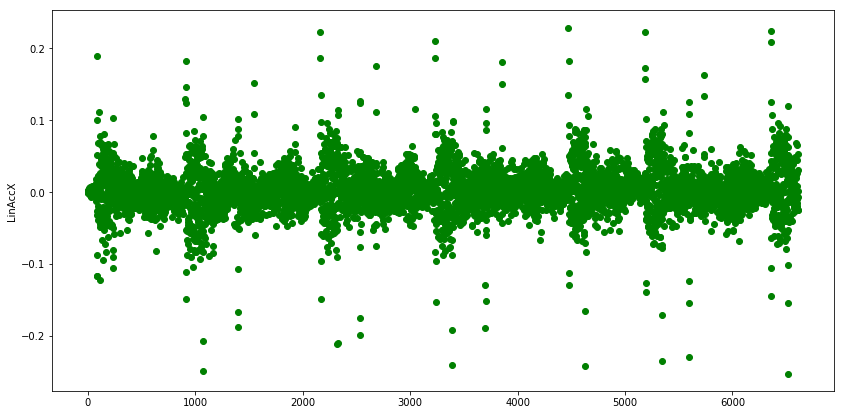

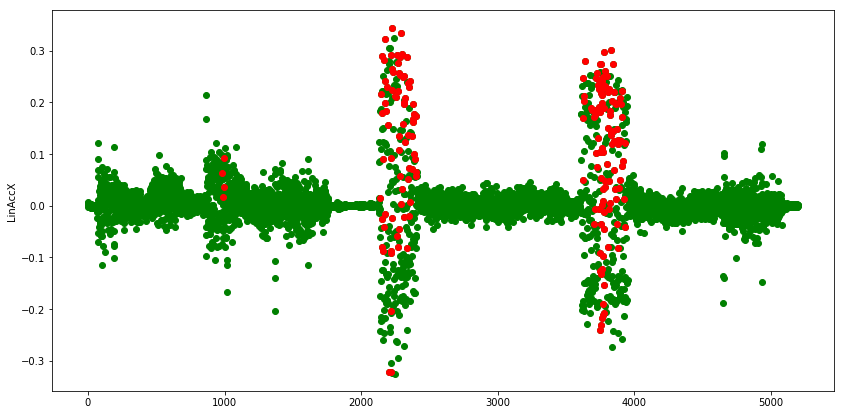

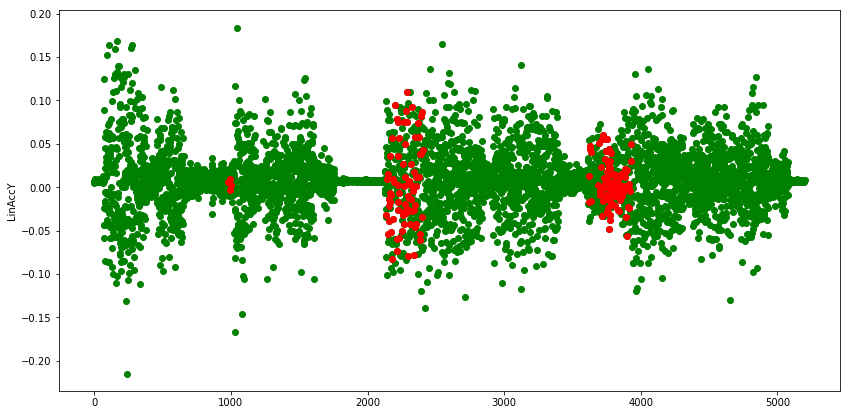

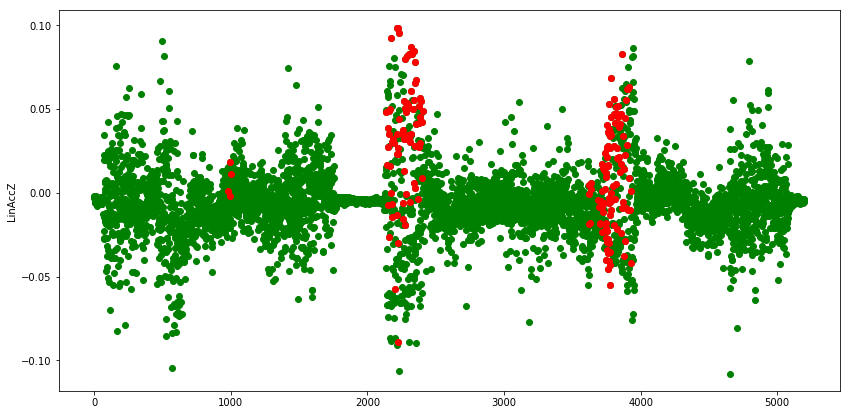

In [10]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(14, 7)

plt.plot(list(range(len(iot_raw[" LinAccX (g)"]))), iot_raw[" LinAccX (g)"], "go")
plt.ylabel('LinAccX')
plt.show()

plt.plot(list(range(len(verify_raw[" LinAccX (g)"]))), verify_raw[" LinAccX (g)"], "go", x,verify_raw[" LinAccX (g)"][x], "ro")
plt.ylabel('LinAccX')
plt.show()

plt.plot(list(range(len(verify_raw[" LinAccY (g)"]))), verify_raw[" LinAccY (g)"], "go", x,verify_raw[" LinAccY (g)"][x], "ro")
plt.ylabel('LinAccY')
plt.show()

plt.plot(list(range(len(verify_raw[" LinAccZ (g)"]))), verify_raw[" LinAccZ (g)"], "go", x,verify_raw[" LinAccZ (g)"][x], "ro")
plt.ylabel('LinAccZ')
plt.show()